In [1]:
import kmodels as kmk
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from torch.nn import functional as F
import pickle
import gc

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_pickle(r'kmk\data\SeparatedData_MedFilt_v2-Copy1.pkl')
leave_out_subject = 'R'

In [13]:
leave_out_df = df[df['Subject'] == 'RGr10']
train_df = df[df['Subject'] != 'RGr10']
window_size = 100
stride = window_size
train_data = kmk.Dataset_LSTM_experimental(train_df, window_size=window_size, stride=stride)
train_data = kmk.Dataset_LSTM_experimental(leave_out_df, window_size=window_size, stride=stride)

In [24]:
models = kmk.random_models_LSTM(25, batch_size_range=(2, len(train_data)), n_linear_layers_range=(2, 4))
models

,lstm_hidden_size,n_linear_layers,layer_size,lstm_n_outputs,batch_size,learning_rate
0,84,2,60,36,3.0,0.085045
1,36,3,83,32,15.0,0.069828
2,38,3,78,37,8.0,0.059201
3,84,2,73,39,2.0,0.028308
4,51,2,90,37,7.0,0.066044
5,23,3,32,71,7.0,0.020559
6,88,2,13,24,10.0,0.050116
7,47,3,99,94,3.0,0.033326
8,81,3,71,65,11.0,0.065868
9,94,2,23,87,15.0,0.066987


In [25]:
results = kmk.train_LSTMs(models, train_data, train_data, n_epochs=200)

tensor([[-0.0042,  0.0448, -0.1440,  ...,  0.1470,  0.0209,  0.1129],
        [-0.0048,  0.0436, -0.1442,  ...,  0.1478,  0.0200,  0.1130],
        [-0.0056,  0.0422, -0.1441,  ...,  0.1481,  0.0194,  0.1129],
        ...,
        [-0.0087,  0.0357, -0.1470,  ...,  0.1491,  0.0182,  0.1117],
        [-0.0087,  0.0357, -0.1470,  ...,  0.1493,  0.0183,  0.1117],
        [-0.0087,  0.0357, -0.1470,  ...,  0.1494,  0.0183,  0.1117]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
lstm(
  (lstm): LSTM(8, 84, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=84, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=60, bias=True)
  )
  (output): Linear(in_features=60, out_features=300, bias=True)
)
training model 0
batch_size 3.0
training data size 42
testing data size 6
shape of training data torch.Size([42, 100, 8]) torch.Size([42, 300])
shape of testing data torch.Size([6, 100, 8]) torch.Size([6, 300])
EPOCH :  0 , dt:  0.25711488723754883 seconds, l

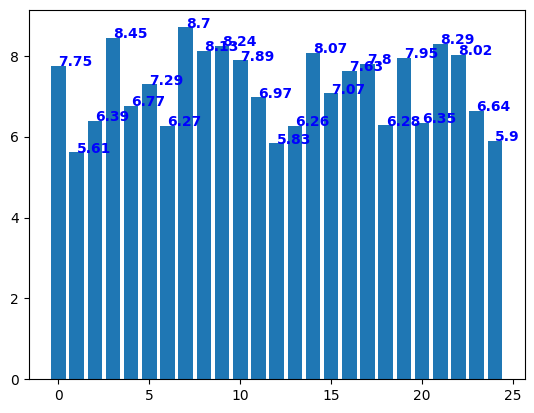

In [35]:
plt.bar(range(len(results[3])), results[3]['mae'])
# put the mae on the bars
for i, v in enumerate(results[3]['mae']):
    plt.text(i, v, str(round(v, 2)), color='blue', fontweight='bold')
    

In [131]:
sim_df = pd.read_pickle(r'C:\Users\efons\Desktop\kalyn_lstm\kmk\data\LP_Simulations_Formatted.pkl')
window_size = 100
stride = window_size
sim_df.columns

Index(['Time', 'FCU', 'EPL', 'EPB', 'FPL', 'APL', 'FPB', 'OPP', 'Fx', 'Fy',
       'Fz', 'ADD', 'Subject'],
      dtype='object')

In [132]:
# first lets split the dataframe into a train and test set using the Subject column. Keep subjects separate during training and testing
#df = dd.from_pandas(df, npartitions=4)
subject_dfs = kmk.split_df_into_subjects(sim_df)
train_split = 0.9
n_train_subjects = int(len(subject_dfs) * train_split)
n_test_subjects = len(subject_dfs) - n_train_subjects


In [133]:
# randomly pick the subjects to use for training and testing
train_subjects_index = np.random.choice(len(subject_dfs), n_train_subjects, replace=False)
train_df_sim = pd.concat([subject_dfs[i] for i in train_subjects_index])
test_df_sim = pd.concat([subject_dfs[i] for i in range(len(subject_dfs)) if i not in train_subjects_index])


In [134]:
train_data_sim = kmk.Dataset_LSTM_opensim(train_df_sim, sort_column=['Subject'], window_size=window_size, stride=stride)

In [135]:
test_data_sim = kmk.Dataset_LSTM_opensim(test_df_sim, sort_column=['Subject'], window_size=window_size, stride=stride)

In [136]:
train_data_sim.X = torch.from_numpy(train_data_sim.X).float()
train_data_sim.Y = torch.from_numpy(train_data_sim.Y).float()
test_data_sim.X = torch.from_numpy(test_data_sim.X).float()
test_data_sim.Y = torch.from_numpy(test_data_sim.Y).float()

In [137]:
train_data_sim

Text(0, 0.5, 'Force')

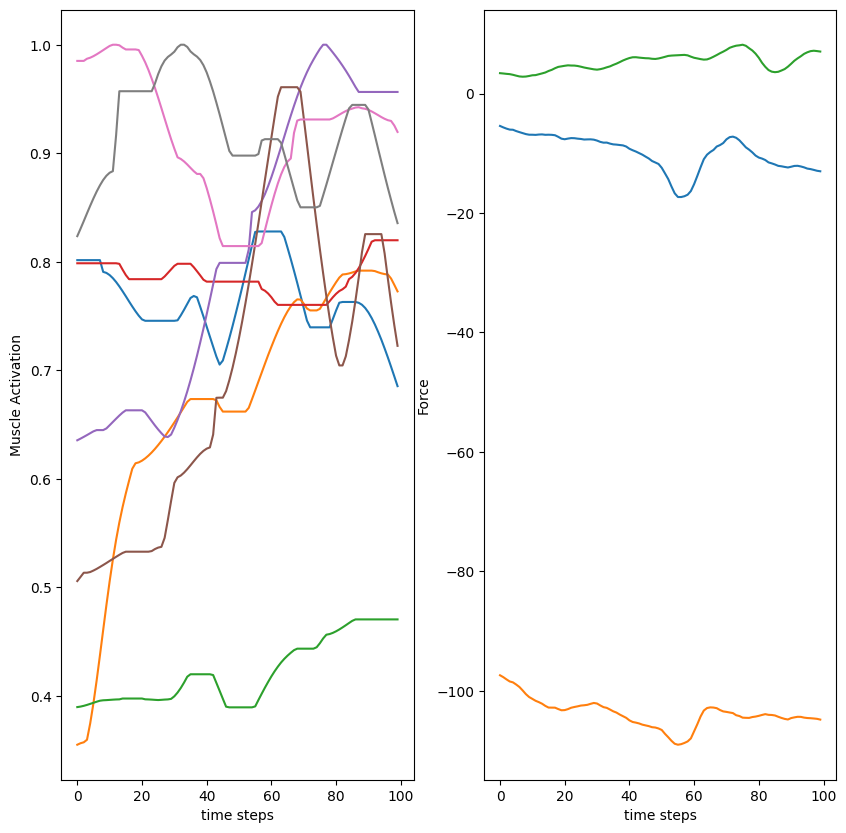

In [138]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(train_data[1][0])
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Muscle Activation')
ax[1].plot(train_data[1][1])
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')

In [139]:
#model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
best_model_index = np.argmin(results[3]['mae'])
model = results[0]
learning_rate = results[2]['learning_rate'][best_model_index]
batch_size = results[2]['batch_size'][best_model_index]
batch_size = 224
batch_size

224

In [140]:
losses = kmk.run_Pytorch(model, train_data_sim.X.reshape(-1, 100, 8), train_data_sim.Y, n_epochs=101, batch_size=batch_size, learning_rate=learning_rate, device='cuda')

EPOCH :  0 , dt:  1.3593590259552002 seconds, losses : 4.878749847412109
EPOCH :  10 , dt:  13.512465238571167 seconds, losses : 4.005932807922363
EPOCH :  20 , dt:  14.620149612426758 seconds, losses : 4.396310329437256
EPOCH :  30 , dt:  15.742397785186768 seconds, losses : 4.309403419494629
EPOCH :  40 , dt:  14.093822956085205 seconds, losses : 13.035242080688477
EPOCH :  50 , dt:  14.106273174285889 seconds, losses : 12.39998722076416
EPOCH :  60 , dt:  14.100932121276855 seconds, losses : 9.003644943237305
EPOCH :  70 , dt:  14.412986993789673 seconds, losses : 6.5798187255859375
EPOCH :  80 , dt:  13.300137042999268 seconds, losses : 6.065465927124023
EPOCH :  90 , dt:  13.360353231430054 seconds, losses : 6.513302326202393
EPOCH :  100 , dt:  13.082019805908203 seconds, losses : 6.010401725769043


In [141]:
def TLLSTM(model, X, change_layers=1):
    new = kmk.lstm(n_linear_layers=model.n_linear_layers, n_outputs=model.output.out_features, lstm_n_outputs=model.lstm_n_outputs, layer_size=model.layer_size, hidden_size=36)
    test = new(X)
    new.load_state_dict(model.state_dict())
    children = [child for child in new.children()]
    for child in children:
        for param in child.parameters():
            param.requires_grad = False
    total_layers = len(children)
    for i in range(change_layers):
        layer = children[total_layers-i-1]
        layer_params = layer.parameters()
        for p in layer_params:
            p.requires_grad = True
    return new

# makes make another TLMLSTM_newlayers function
def TLMLSTM_newlayers(model, X, change_layers=1, new_layer_size=10):
    new = kmk.lstm(n_linear_layers=model.n_linear_layers, 
               n_outputs=model.output.out_features, 
               lstm_n_outputs=model.lstm_n_outputs, 
               layer_size=model.layer_size)
    test = new(X)
    new.load_state_dict(model.state_dict())
    children = [child for child in new.children()]
    for child in children:
        for param in child.parameters():
            param.requires_grad = False
    total_layers = len(children)
    # add the new layers
    new.new_layer_size = new_layer_size
    new.layers = len(new.fcs) + change_layers
    for i in range(change_layers):
        if i == 0:
            new.fcs.append(nn.Linear(new.layer_size, new.new_layer_size))
        else:
            new.fcs.append(nn.Linear(new.new_layer_size, new.new_layer_size))
            # make sure the new layers are trainable
        new.fcs[-1].requires_grad = True
    # make the new output layer 
    new.output = nn.Linear(new.new_layer_size, new.output.out_features)
    return new

In [142]:
tlm = TLLSTM(model, train_data_sim.X[0].reshape(1, 100, 8), change_layers=3)
tlm

lstm(
  (lstm): LSTM(8, 36, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3600, out_features=83, bias=True)
    (1): Linear(in_features=83, out_features=83, bias=True)
    (2): Linear(in_features=83, out_features=83, bias=True)
  )
  (output): Linear(in_features=83, out_features=300, bias=True)
)

In [143]:
loss_tlm = kmk.run_Pytorch(tlm, train_data.X, train_data.Y, n_epochs=2001, batch_size=results[2].iloc[best_model_index]['batch_size'], learning_rate=learning_rate, device='cuda')

EPOCH :  0 , dt:  0.787522554397583 seconds, losses : 628.5984497070312
EPOCH :  10 , dt:  7.815633296966553 seconds, losses : 177.51927185058594
EPOCH :  20 , dt:  7.820974111557007 seconds, losses : 107.70654296875
EPOCH :  30 , dt:  7.961497783660889 seconds, losses : 55.220237731933594
EPOCH :  40 , dt:  8.390445947647095 seconds, losses : 66.9842300415039
EPOCH :  50 , dt:  8.171732902526855 seconds, losses : 34.22039031982422
EPOCH :  60 , dt:  8.57479739189148 seconds, losses : 34.36434555053711
EPOCH :  70 , dt:  7.734524726867676 seconds, losses : 16.21135711669922
EPOCH :  80 , dt:  7.806973934173584 seconds, losses : 123.2694320678711
EPOCH :  90 , dt:  7.982327461242676 seconds, losses : 64.86911010742188
EPOCH :  100 , dt:  7.766332387924194 seconds, losses : 55.34458923339844
EPOCH :  110 , dt:  7.8996758460998535 seconds, losses : 42.3835563659668
EPOCH :  120 , dt:  8.14854097366333 seconds, losses : 36.461952209472656
EPOCH :  130 , dt:  7.716547966003418 seconds, loss

KeyboardInterrupt: 

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Learning Curve'}, xlabel='Epoch', ylabel='Loss'>)

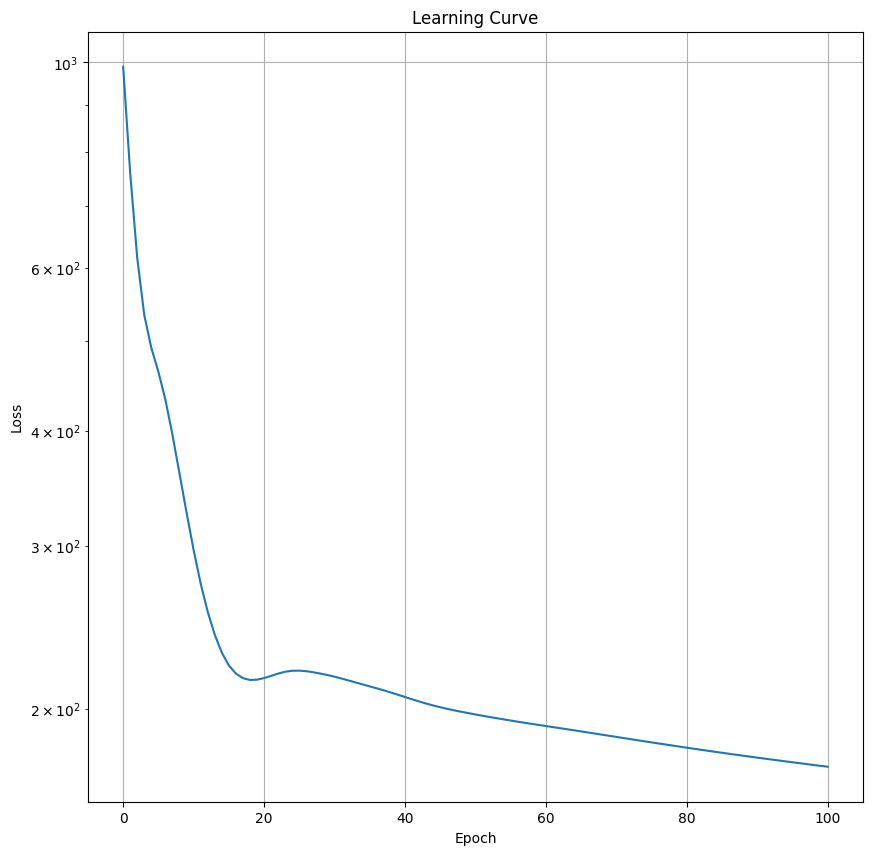

In [ ]:
# now to plot a paper worthy learning curve of the model. Make the line stand out in a clean cartoonish way. Make the y axis
# log scale. 
def plot_learning_curve(losses, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10)):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.plot(losses)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale('log')
    # add a grid
    ax.grid()
    return fig, ax
plot_learning_curve(loss_tlm, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10))

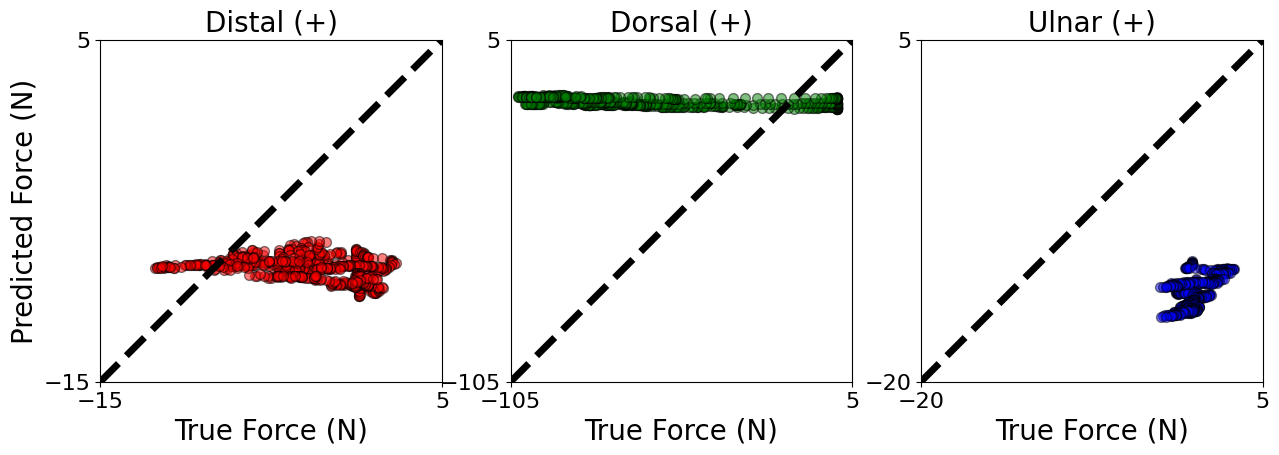

In [157]:
figname = 'FFNN_FineTuned_ExpTest.png'
import math
# Functions
def roundup(x, nearest = 5):
    return int(math.ceil(x / nearest)) * nearest

def rounddown(x, nearest = 5):
    return int(math.floor(x / nearest)) * nearest

# Parity subplots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
Y = test_data.Y.reshape(-1,3).detach().cpu().numpy()
pred = model(test_data.X.reshape(-1, 100, 8)).detach().cpu().numpy().reshape(-1,3)
X_true = Y[:,0]
X_pred = pred[:,0]
Y_true = Y[:,1]
Y_pred = pred[:,1]
Z_true = Y[:,2]
Z_pred = pred[:,2]

# Plot predictions of X 
ax1.scatter(X_true, X_pred, s=50, alpha=0.5, edgecolors='k', color='red')
ax1.set_title('Distal (+)', fontsize = 20)
ax1.set_xlabel('True Force (N)', fontsize = 20)
ax1.set_ylabel('Predicted Force (N)', fontsize = 20)
ax1.set_aspect('equal')

# Set min and max range for axes
alldata = np.concatenate((np.array(X_true), X_pred), axis=0)
max_range = roundup(alldata.max())
min_range = rounddown(alldata.min())
ax1.set_xlim(min_range, max_range)
ax1.set_ylim(min_range, max_range)
ax1.set_xticks([min_range, max_range])
ax1.set_yticks([min_range, max_range])
ax1.tick_params(axis='both', which = 'major', labelsize = 16)

ax1.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax1.transAxes)



# Plot predictions of Y
ax2.scatter(Y_true, Y_pred, s=50, alpha=0.5, edgecolors='k', color = 'green')
ax2.set_title('Dorsal (+)', fontsize = 20)
ax2.set_xlabel('True Force (N)', fontsize = 20)
ax2.set_aspect('equal')

# Set min and max range for axes
alldata = np.concatenate((np.array(Y_true), Y_pred), axis=0)
max_range = roundup(alldata.max())
min_range = rounddown(alldata.min())
ax2.set_xlim(min_range, max_range)
ax2.set_ylim(min_range, max_range)
ax2.set_xticks([min_range, max_range])
ax2.set_yticks([min_range, max_range])
ax2.tick_params(axis='both', which = 'major', labelsize = 16)

ax2.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax2.transAxes)




# Plot predictions of Z
ax3.scatter(Z_true, Z_pred, s=50, alpha=0.5, edgecolors='k', color = 'blue')
ax3.set_title('Ulnar (+)', fontsize = 20)
ax3.set_xlabel('True Force (N)', fontsize = 20)
ax3.set_aspect('equal')

# Set min and max range for axes
alldata = np.concatenate((np.array(Z_true), Z_pred), axis=0)
max_range = roundup(alldata.max())
min_range = rounddown(alldata.min())
ax3.set_xlim(min_range, max_range)
ax3.set_ylim(min_range, max_range)
ax3.set_xticks([min_range, max_range])
ax3.set_yticks([min_range, max_range])
ax3.tick_params(axis='both', which = 'major', labelsize = 16)

ax3.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax3.transAxes)
plt.savefig(figname, dpi = 600)

6
(600, 3)
(600, 3)
[ -4.926916  -55.855904    0.7362852]


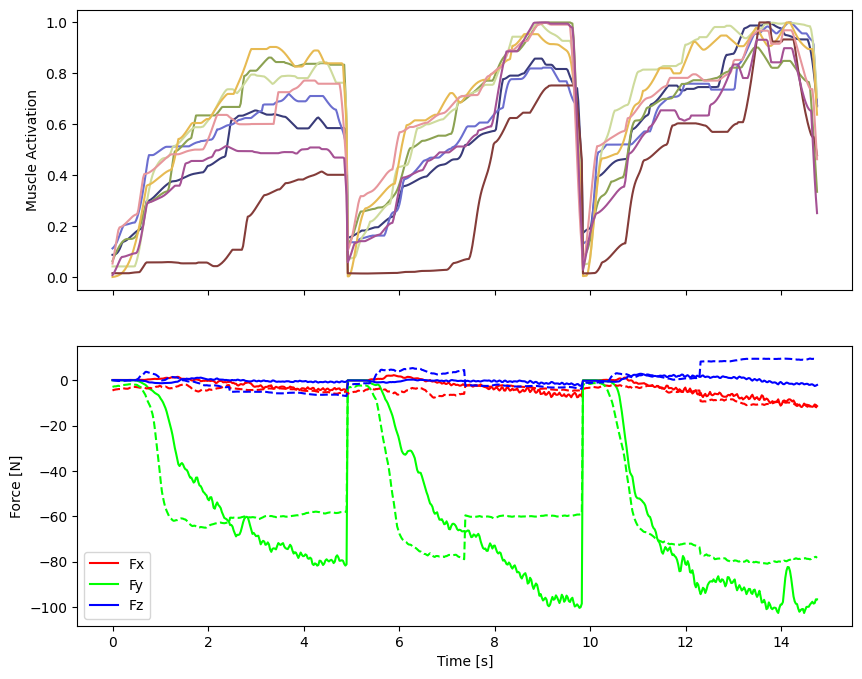

In [158]:
# plot a sample of the data

# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]

n = np.random.randint(0, len(test_data.X))
print(len(test_data.X))
x_plot = test_data.X.reshape(-1, 8).float().detach().cpu().numpy()
y_plot = test_data.Y.reshape(-1, 3).float().detach().cpu().numpy()
dt = test_data.df['Time'].iloc[1] - test_data.df['Time'].iloc[0]
time = np.arange(0, x_plot.shape[0]*dt, dt)
print(y_plot.shape)
y_labels = test_data.ycols
x_labels = test_data.xcols
# lets remake this plot but make the two subplots share the x axis
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)  
# make sure the colors for xplot do not overlap with yplot. Make xplot from the viridis colormap. there are 8 columns in xplot
for i in range(x_plot.shape[1]):
    ax[0].plot(time, x_plot[:,i], color=plt.cm.tab20b(i/x_plot.shape[1]))
ax[0].set_ylabel('Muscle Activation')    
# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]
for i in range(y_plot.shape[1]):
    ax[1].plot(time, y_plot[:,i], color=line_colors[i])
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Force [N]')
ax[1].legend(y_labels)
#plot the prediction of this sample 
pred = tlm(test_data.X.to('cuda')).detach().cpu().numpy().reshape(-1, 3)
print(pred.shape)
for i in range(pred.shape[1]):
    ax[1].plot(time, pred[:,i], color=line_colors[i], linestyle='--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)

6
(600, 3)
(600, 3)
[ -4.926916  -55.855904    0.7362852]


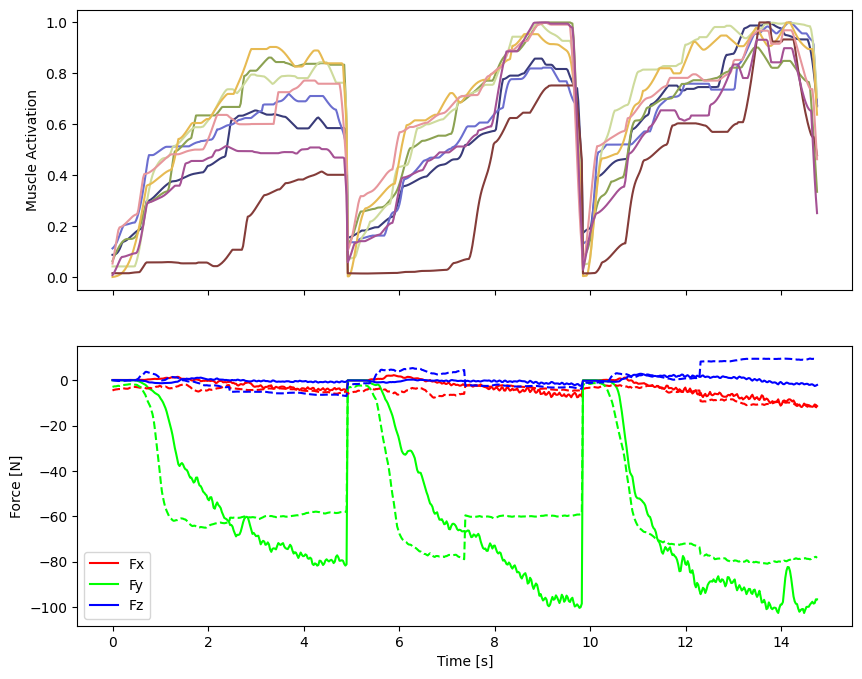

In [159]:
# plot a sample of the data

# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]

n = np.random.randint(0, len(test_data.X))
print(len(test_data.X))
x_plot = test_data.X.reshape(-1, 8).float().detach().cpu().numpy()
y_plot = test_data.Y.reshape(-1, 3).float().detach().cpu().numpy()
dt = test_data.df['Time'].iloc[1] - test_data.df['Time'].iloc[0]
time = np.arange(0, x_plot.shape[0]*dt, dt)
print(y_plot.shape)
y_labels = test_data.ycols
x_labels = test_data.xcols
# lets remake this plot but make the two subplots share the x axis
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)  
# make sure the colors for xplot do not overlap with yplot. Make xplot from the viridis colormap. there are 8 columns in xplot
for i in range(x_plot.shape[1]):
    ax[0].plot(time, x_plot[:,i], color=plt.cm.tab20b(i/x_plot.shape[1]))
ax[0].set_ylabel('Muscle Activation')    
# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]
for i in range(y_plot.shape[1]):
    ax[1].plot(time, y_plot[:,i], color=line_colors[i])
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Force [N]')
ax[1].legend(y_labels)
#plot the prediction of this sample 
pred = tlm(test_data.X.to('cuda')).detach().cpu().numpy().reshape(-1, 3)
print(pred.shape)
for i in range(pred.shape[1]):
    ax[1].plot(time, pred[:,i], color=line_colors[i], linestyle='--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)

42
(4200, 3)
(4200, 3)
[ 5.113504  64.10998    3.6820729]


(0.0, 20.0)

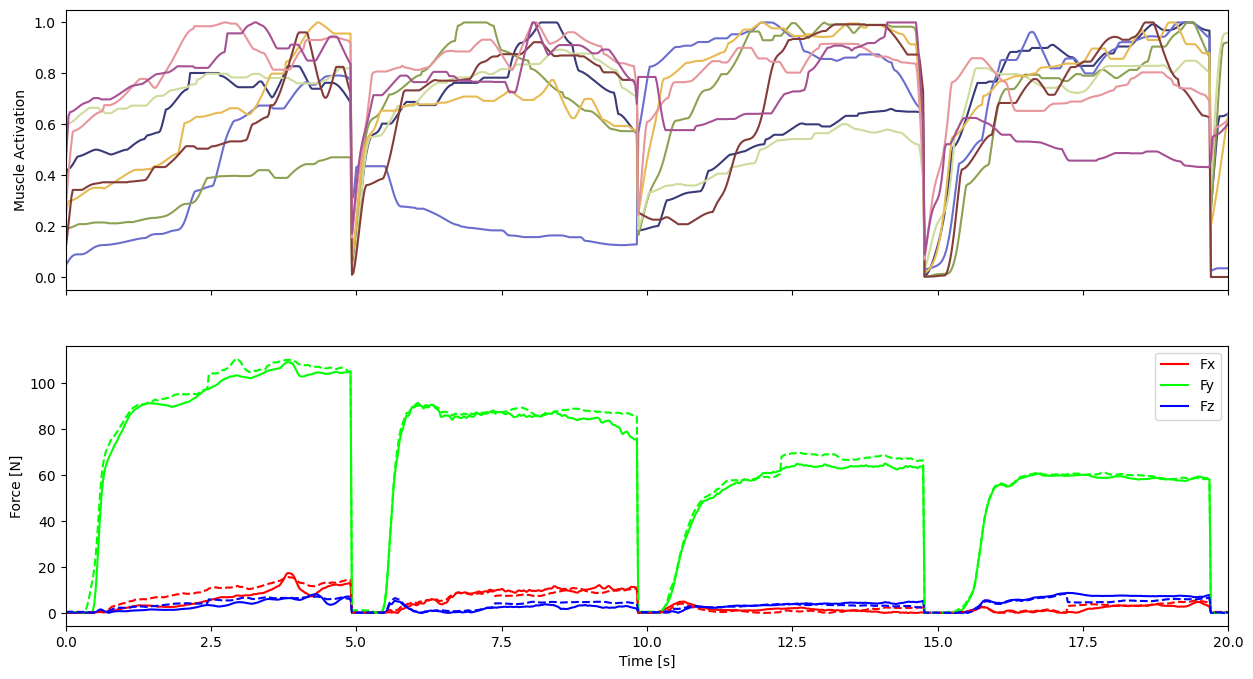

In [160]:
# plot a sample of the data

# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]

n = np.random.randint(0, len(train_data.X))
print(len(train_data.X))
x_plot = np.abs(train_data.X.reshape(-1, 8).float().detach().cpu().numpy())
y_plot = np.abs(train_data.Y.reshape(-1, 3).float().detach().cpu().numpy())
dt = train_data.df['Time'].iloc[1] - train_data.df['Time'].iloc[0]
time = np.arange(0, x_plot.shape[0]*dt, dt)
print(y_plot.shape)
y_labels = train_data.ycols
x_labels = train_data.xcols
# lets remake this plot but make the two subplots share the x axis
fig, ax = plt.subplots(2, 1, figsize=(15,8), sharex=True)  
# make sure the colors for xplot do not overlap with yplot. Make xplot from the viridis colormap. there are 8 columns in xplot
for i in range(x_plot.shape[1]):
    ax[0].plot(time, x_plot[:,i], color=plt.cm.tab20b(i/x_plot.shape[1]))
ax[0].set_ylabel('Muscle Activation')    
# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]
for i in range(y_plot.shape[1]):
    ax[1].plot(time, y_plot[:,i], color=line_colors[i])
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Force [N]')
ax[1].legend(y_labels)
#plot the prediction of this sample 
pred = np.abs(tlm(train_data.X.to('cuda')).detach().cpu().numpy().reshape(-1, 3))
print(pred.shape)
for i in range(pred.shape[1]):
    ax[1].plot(time, pred[:,i], color=line_colors[i], linestyle='--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)
#ax[1].set_yscale('log')
ax[1].set_xlim([0, 20])